In [1]:
#导入库
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib notebook

In [2]:
device = torch.device("cuda")

In [3]:
#kwargs =  if use_cuda else {}
ana_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
        transform=transforms.ToTensor()),
            batch_size=640, shuffle=False, num_workers= 16, pin_memory= True)

In [4]:
%%time

data_im={0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[]};
data_la={0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[]};

data_s=0;
for i, (data,target) in enumerate(ana_loader):
    data_len=target.shape[0]
    for data_len_i in range(data_len):
        data_it_5=data[data_len_i][0];
        data_it_l=target[data_len_i];
        data_it_t=target.numpy()[data_len_i]
        #print((data_it_t))
        data_im[data_it_t].append(data_it_5)
        data_la[data_it_t].append(data_it_l)
        #.append(data_it_5)
    if(data_s>100):
        break;

#打印各个类别数量
print([len(data_im[i]) for i in range(10)])


[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]
CPU times: user 17.8 s, sys: 686 ms, total: 18.5 s
Wall time: 3.05 s


In [5]:
#网络定义
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 10000)
        self.fc2 = nn.Linear(10000, 10000)
        self.fc3 = nn.Linear(10000, 28*28)

    def forward(self, x):
        x = x.view(-1, 28*28)
        
        #模拟RNN产生联想的效果
        dec = torch.tanh(self.fc2(torch.tanh(self.fc1(x))))
        x = torch.tanh(self.fc3(dec))
        
        #dec = F.relu(self.fc2(F.relu(self.fc1(x))))
        #x = torch.tanh(self.fc3(dec))
        #
        #dec = F.relu(self.fc2(F.relu(self.fc1(x))))
        #x = torch.tanh(self.fc3(dec))
        #
        #dec = F.relu(self.fc2(F.relu(self.fc1(x))))
        #x = torch.tanh(self.fc3(dec))
        #
        #dec = F.relu(self.fc2(F.relu(self.fc1(x))))
        #x = torch.tanh(self.fc3(dec))
        
        return x,dec

model = Net().cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
ceriation = nn.CrossEntropyLoss().cuda()
loss2 = nn.MSELoss().cuda()

#Train
model.train()
model_loss=[]

for epoch in range(1, 3000):
    optimizer.zero_grad()
    data_5_0=data_im[epoch%10][0].cuda();
    data, target = data_im[epoch%10][epoch%10].cuda(), data_la[epoch%10][epoch%10].cuda()
    output,dec = model(data)
    loss = loss2(output, data_5_0.view(-1,28*28))
    loss.backward()
    optimizer.step()
    model_loss.append(loss.item())
    if(epoch%500==0):
        print(epoch,':',loss.item())

500 : 0.0383547767997
1000 : 0.0232430305332
1500 : 0.0141987772658
2000 : 0.009092672728
2500 : 0.00622405437753


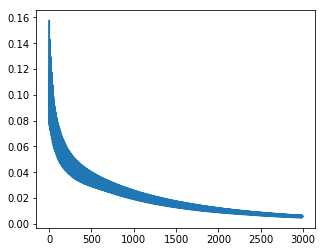

In [6]:
#loss曲线
%matplotlib inline
plt.figure(figsize=(5,4))
#for data_i in range(data_s):
plt.plot(model_loss)
plt.show()

<IPython.core.display.Javascript object>


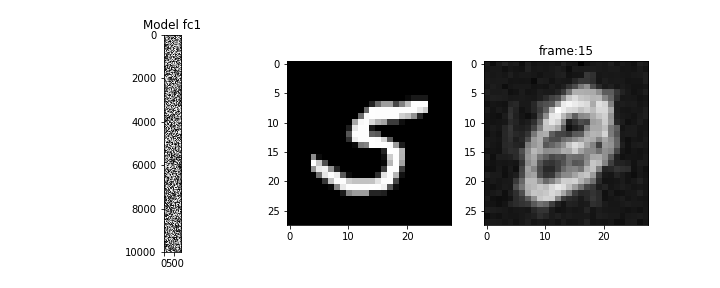

In [8]:
#Test
%matplotlib notebook

fig = plt.figure(figsize=(10,4));
def updatefig(epoch):
    model.eval()
    data, target = data_im[epoch%10][epoch], data_la[epoch%10][epoch]
    output,dec = model.cpu()(data)
    output,dec = model(output)
    output,dec = model(output)
    plt.subplot(1,3,1)
    plt.imshow(model.fc1.weight.data.cpu().numpy(), cmap='gray')
    plt.title('Model fc1')
    plt.subplot(1,3,2)
    #plt.plot(dec.view(-1).detach().numpy(),'r')
    plt.imshow(data.view(28,28).detach().numpy(),cmap='gray')
    plt.subplot(1,3,3)
    plt.imshow(output.view(28,28).detach().numpy(),cmap='gray')
    plt.title(''.join(['frame:',str(epoch)]))

ani = animation.FuncAnimation(fig, updatefig, frames=100,interval=200, blit=True)